<h1> Classification Model

#### _Installs, imports and paths_

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

from time import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

2023-01-05 18:53:29.184063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path_csv = '../data/x-ai_data.csv'
path_img = "../data/images/"
path_img_classified = "../data/images_classified/"

## Load data

In [4]:
data_info = pd.read_csv(path_csv)
print(data_info.shape)
data_info.head(3)

(1999, 3)


,filename,class,split
0,silos_256-0-0--6-15--152-30320.png,0,validation
1,silos_256-0-0--6-15--1195-31353.png,0,train
2,silos_256-0-0--6-15-283-30628.png,0,train


## Split pictures according to labels
_To be done once_

In [7]:
import os
 
source = '../data/images'
destination = '../data/images_classified/not_silos'
 
# gather all files
allfiles = data_info[data_info['class'] == 0].filename.values
 
# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

In [13]:
imgs = [fn for fn in os.listdir(f'{path_img}') if fn.endswith('.png')]
silos_imgs = [fn for fn in os.listdir('../data/images_classified/silos/') if fn.endswith('.png')]
not_silos_imgs = [fn for fn in os.listdir('../data/images_classified/not_silos/') if fn.endswith('.png')]

In [14]:
# Check the number of files
print(f"Number of images : {len(imgs)}.")
print(f"Number of silos : {len(silos_imgs)}.")
print(f"Number of not_silos : {len(not_silos_imgs)}.")

Number of images : 1999.
Number of silos : 999.
Number of not_silos : 1999.


In [15]:
# making n X m matrix
def img2np(path, list_of_filename, size=(256, 256, 3)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        # print(fp)
        current_image = image.load_img(fp, target_size=size)
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [16]:
# run it on our folders
silos_images_2 = img2np(f'{path_img_classified}silos/', silos_imgs)

In [17]:
# run it on our folders
silos_images = img2np(f'{path_img_classified}silos/', silos_imgs)

In [18]:
not_silos_images = img2np(f'{path_img_classified}not_silos/', not_silos_imgs)

In [19]:
(silos_images_2 == silos_images).all()

True

In [ ]:
image_size = (256, 256)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_img_classified,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_img_classified,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2998 files belonging to 2 classes.
Using 2399 files for training.


2023-01-05 19:35:05.623433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2998 files belonging to 2 classes.
Using 599 files for validation.


In [21]:
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
CHANNELS = 3
IMG_SIZE = 256

In [22]:
from tensorflow.keras.utils import img_to_array, array_to_img
def crop_add(im):
    array = img_to_array(im)
    if tf.random.uniform(()) > 0.5:
        array_bottom = array[:128,:,:].copy()
        array[:128,:,:] = array[128:,:,:]
        array[128:,:,:] = array_bottom
    im_crop = array_to_img(array)
    return im_crop


In [23]:
def parse_function_train(filename, label, seed=(1, 2)):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    
    # Random brightness.
    #image_augmented1 = tf.image.stateless_random_brightness(
    #    image_normalized, max_delta=0.2, seed=seed)
    # image_augmented = tf.image.stateless_random_contrast(
    #     image_augmented, lower=0.4, upper=0.6, seed=seed)
    # image_augmented = tf.image.stateless_random_saturation(
    #     image_augmented, lower=0.4, upper=0.6, seed=seed)
    # image_augmented = tf.image.stateless_random_jpeg_quality(
    #     image_augmented, min_jpeg_quality=75, max_jpeg_quality=100, seed=seed)
    #image_augmented2 = tf.image.stateless_random_flip_left_right(image_normalized, seed=seed)
    #image_augmented3 = tf.image.stateless_random_flip_up_down(image_normalized, seed)
    
    data_augmentation = tf.keras.Sequential([
      layers.RandomFlip(mode="horizontal_and_vertical", seed=seed),
      layers.RandomRotation(factor=0.2, seed=seed)])
    
    image_augmented1 = data_augmentation(image_normalized)
    image_augmented2 = data_augmentation(image_normalized)
    image_augmented3 = data_augmentation(image_normalized)
    image_augmented4 = data_augmentation(image_normalized)

    
    return [(image_normalized, label), 
            (image_augmented1, label), 
            (image_augmented2, label), 
            (image_augmented3, label), 
            (image_augmented4, label)]

In [24]:
def parse_function(filename, label, seed=(1, 2)):
    """
    Function that returns a tuple of normalized image array and labels array.
    This parse function doesn't shuffle nor does data augmentation. 
    It is thus meant for the validation dataset.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

In [25]:
def create_dataset(filenames, labels, is_training=True):
    """
    Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    if is_training == True:
        # Parse and preprocess observations in parallel
        dataset = dataset.map(parse_function_train, num_parallel_calls=AUTOTUNE)

        names = []
        labels = []
        for group_image in dataset:
            for element in group_image: 
                names += [element[0]]
                labels += [element[1]]
        dataset = tf.data.Dataset.from_tensor_slices((names, labels))
        
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=len(list(dataset)))
    else:
        # Parse and preprocess observations in parallel
        dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
        
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [26]:
X_train = data_info[data_info['split'] == 'train'].filename.values
y_train = data_info[data_info['split'] == 'train']['class'].values

X_val = data_info[data_info['split'] == 'validation'].filename.values
y_val = data_info[data_info['split'] == 'validation']['class'].values

In [27]:
X_train = [os.path.join(path_img, str(f)) for f in X_train]
X_val = [os.path.join(path_img, str(f)) for f in X_val]

In [28]:
pd.DataFrame(X_train).head(3)

,0
0,../data/images/silos_256-0-0--6-15--1195-31353...
1,../data/images/silos_256-0-0--6-15-283-30628.png
2,../data/images/silos_256-0-0--6-15--404-30011.png


In [29]:
start = time()
train_ds = create_dataset(X_train, y_train, is_training=True)
val_ds = create_dataset(X_val, y_val, is_training=False)
print(round(time()-start, 2))

26.44


In [30]:
number_of_train_images = len(y_train)*5
print(f"Actual length: {number_of_train_images}.")

Actual length: 6995.


In [31]:
b = (len(list(train_ds))-1)*32
c = len(list(train_ds))*32
print(f"Actual length between {b} and {c} :")
print((number_of_train_images > b) and (number_of_train_images < c))

Actual length between 6976 and 7008 :
True


In [32]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (32, 256, 256, 3)
Shape of labels array: (32,)


In [33]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256]:#[256, 512, 728]:
        # x = layers.Activation("relu")(x)
        # x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [34]:
model = make_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [35]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [36]:
from tensorflow.keras.optimizers import RMSprop, Adam

In [37]:
LR = 0.0001
# BATCH_SIZE = 128

In [38]:
model = tf.keras.models.Sequential([ 
  
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),     
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer=RMSprop(learning_rate=LR), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(), "accuracy"])


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 62, 62, 32)        0

In [40]:
EPOCHS = 100

In [41]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[
                            tf.keras.callbacks.ModelCheckpoint(
                                os.path.join('test_models/', 
                                             'model_Camille_data_augmented_3/epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5'),
                                monitor='val_auc', save_best_only=True
                            )
                    ]
                   )

print(f'Training took {round(time()-start, 2)} sec')

Epoch 1/100
219/219 [==============================] - 155s 699ms/step - loss: 6.7943 - auc: 0.5929 - accuracy: 0.5674 - val_loss: 3.7215 - val_auc: 0.7129 - val_accuracy: 0.5150
Epoch 2/100
219/219 [==============================] - 146s 668ms/step - loss: 2.4151 - auc: 0.6148 - accuracy: 0.5821 - val_loss: 2.0737 - val_auc: 0.7178 - val_accuracy: 0.5150
Epoch 3/100
219/219 [==============================] - 146s 667ms/step - loss: 1.4847 - auc: 0.6340 - accuracy: 0.5993 - val_loss: 1.6184 - val_auc: 0.7272 - val_accuracy: 0.5150
Epoch 4/100
219/219 [==============================] - 146s 666ms/step - loss: 1.1962 - auc: 0.6521 - accuracy: 0.6097 - val_loss: 1.3353 - val_auc: 0.6867 - val_accuracy: 0.5150
Epoch 5/100
219/219 [==============================] - 145s 660ms/step - loss: 1.0738 - auc: 0.6577 - accuracy: 0.6273 - val_loss: 1.0707 - val_auc: 0.3661 - val_accuracy: 0.5150
Epoch 6/100
219/219 [==============================] - 150s 683ms/step - loss: 0.9654 - auc: 0.7055 - acc

In [49]:
def learning_curves(history):
    """
    Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    try:
        auc = history.history['auc']
        val_auc = history.history['val_auc']
    except:
        pass
    try:
        auc = history.history['auc_1']
        val_auc = history.history['val_auc_1']
    except:
        pass
    try:
        auc = history.history['auc_2']
        val_auc = history.history['val_auc_2']
    except:
        pass
    try:
        auc = history.history['auc_3']
        val_auc = history.history['val_auc_3']
    except:
        pass
    
        
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(3, 1, 1)
    plt.tight_layout(h_pad=2)

    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(3, 1, 2)
    plt.plot(range(1, epochs+1), accuracy, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('accuracy')
    plt.title('Training and Validation accuracy')
    # plt.xlabel('epoch')
    
    plt.subplot(3, 1, 3)
    plt.plot(range(1, epochs+1), auc, label='Training AUC')
    plt.plot(range(1, epochs+1), val_auc, label='Validation AUC')
    plt.legend(loc='lower right')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, accuracy, val_accuracy, auc, val_auc

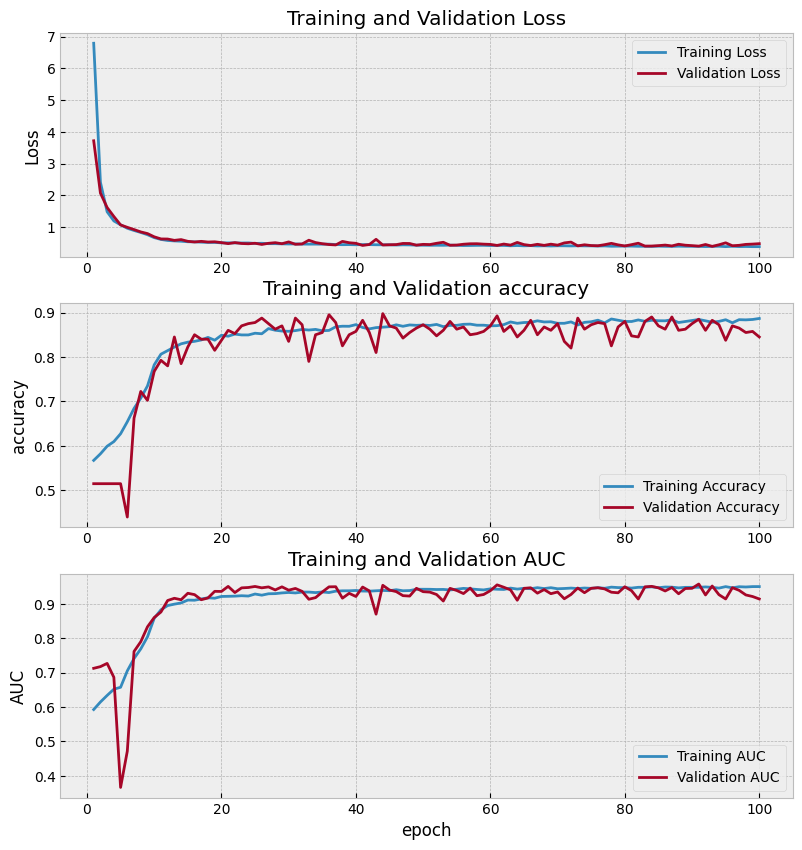

In [51]:
loss, val_loss, accuracy, val_accuracy, auc_2, val_auc_2 = learning_curves(history)

In [53]:
print(f"Best validation accuracy maximum : {np.round(np.max(history.history['val_accuracy']), 3)}.")
print(f"Best validation AUC maximum : {np.round(np.max(history.history['val_auc']), 3)}.")

Best validation accuracy maximum : 0.897.
Best validation AUC maximum : 0.958.


**We keep the model having the best auc score.**

In [54]:
loaded_predictions = model.predict(val_ds)

13/13 [==============================] - 2s 132ms/step


In [56]:
print(f"Final AUC on the validation set : {np.round(np.max(history.history['val_auc']), 3)}.")
print(f"Final accuracy on the validation set : {(y_val==(loaded_predictions>.5).flatten()).sum()*100/len(y_val)}%.")

Final AUC on the validation set : 0.958.
Final accuracy on the validation set : 84.5%.


### Save

In [67]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/classification_model')

INFO:tensorflow:Assets written to: saved_model/classification_model/assets


INFO:tensorflow:Assets written to: saved_model/classification_model/assets


### Load

In [68]:
new_model = tf.keras.models.load_model('saved_model/classification_model')

In [69]:
# Evaluate the model
loss, auc, acc = new_model.evaluate(val_ds, verbose=2)
print("Model accuracy: {:5.2f}%".format(100 * acc))

13/13 - 3s - loss: 0.4800 - auc: 0.9148 - accuracy: 0.8450 - 3s/epoch - 240ms/step
Model accuracy: 84.50%
